In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mtd
import os
import pickle
from calendar import monthrange
import datetime
from sklearn.metrics import mean_squared_error
%matplotlib inline
plt.style.use('seaborn-ticks')

In [2]:
lat = 47.416899
lon = -68.325813
elevation = 151 # (m)
# i) Edmundston Fixed Station (47.416899, -68.325813, 151 m ASL) and 
# ii) Edmundston Mobile trailer (MT) (47.361556, -68.320490, 143 m ASL). 

In [168]:
yr = 2021
mnth = ["April","04"]
days = pd.Period(f'{yr}-{mnth[1]}-01').days_in_month
ind = pd.date_range(f'{int(yr)}-{int(mnth[1])}-21 23:50:00',f'{int(yr)}-{int(mnth[1])}-23 23:29:00',freq='30T')

In [110]:
# Defining the initial and final date
di = datetime.datetime(2021,4,22,0)
df = datetime.datetime(2021,4,24,0)

y = 2021
m = 4
d = 22
hour = 0

# Read data MET tripot
f = '/instruments/SAJESS/FixedStation/met_tripod/2021_04/master'
path = f'{f}/SJ_FS_MET_01_MAS_1min_202104.txt'

df_met = pd.read_csv(path, header=0,parse_dates=[0], infer_datetime_format=True)

df_met = df_met[(df_met['Timestamp']>=di) & (df_met['Timestamp']<=df)] 

# Read data Hot Plate
f_hp = '/instruments/SAJESS/FixedStation/hotplate/2021_04/master/'
path_hp = f'{f_hp}/SJ_FS_HP_MAS_1min_202104.txt'

df_hp = pd.read_csv(path_hp, header=0,parse_dates=[0], infer_datetime_format=True)

df_hp = df_hp[(df_hp['Timestamp']>=di) & (df_hp['Timestamp']<=df)] 

# Read data disdrometer
f_dis = '/instruments/SAJESS/FixedStation/parsivel/2021_04/master/'
path_dis = f'{f_dis}/SJ_FS_DIS_MAS_202104.txt'

df_dis = pd.read_csv(path_dis, header=0,parse_dates=[0], infer_datetime_format=True)

df_dis = df_dis[(df_dis['Timestamp']>=di) & (df_dis['Timestamp']<=df)] 

# Read data flux tripod
f_flux = f"/instruments/SAJESS/FixedStation/flux_tripod/2021_04/master"

typ = "AM"
path_flux = f"{f_flux}/SJ_FS_FLUX_{typ}_202104.txt"
df_fAM = pd.read_csv(path_flux, header=0,parse_dates=[0], infer_datetime_format=True)

typ = "CS"
path_flux = f"{f_flux}/SJ_FS_FLUX_{typ}_202104.txt"
df_fCS = pd.read_csv(path_flux, header=0,parse_dates=[0], infer_datetime_format=True)

df_fAM = df_fAM[(df_fAM['Timestamp']>=di) & (df_fAM['Timestamp']<=df)] 
df_fCS = df_fCS[(df_fCS['Timestamp']>=di) & (df_fCS['Timestamp']<=df)] 

# Reducing the size of the dataframes to plot
df_wind = df_fAM[['Timestamp', 'WD', 'WS', 'WS_MAX']].copy()
df_flux = df_fAM[['Timestamp', 'SW_IN', 'SW_OUT', 'LW_IN', 'LW_OUT']]

# Getting the wind components
# Not sure that I need this
#df_wind['WD_math'] = 270 - df_wind['WD']
df_wind['UU'] = df_wind['WS']*np.cos(df_wind['WD'])
df_wind['VV'] = df_wind['WS']*np.sin(df_wind['WD'])

# get model data

df_model = pickle.load( open( f"data_df_{y}{m:02d}{d:02d}{hour:02d}.p", "rb" ) )
df_model_eta = pickle.load( open( f"data_eta_df_{y}{m:02d}{d:02d}{hour:02d}.p", "rb" ) )
df_model_eta = df_model_eta.dropna(axis=0)
#df_met['Air_Temp_mean'] = df_met['Air_Temp'].rolling(window=15).mean()

df_t2m = df_model[['UU','VV','TT']].copy()
df_t2m['Timestamp'] = df_model['Timestamp'].dt.tz_convert(None)
df_t2m = df_t2m.dropna()

#df_m_flux = df_model[['FI','FB','NR','AL']].copy()
df_model_eta['SW_up'] = df_model_eta['FB']*df_model_eta['AL']
df_model_eta['LW_up'] = df_model_eta['FI'] - df_model_eta['SI']
df_model_eta['Timestamp'] = df_model_eta['Timestamp'].dt.tz_convert(None)
df_m_flux = df_model_eta.copy()
#df_m_flux = df_m_flux.drop(columns='AL')


df_t2m_obs = df_met[['Timestamp', 'Air_Temp']]

# Getting the same values to calculate the RMSE
result = df_t2m_obs.merge(df_t2m)
rmse_TT = mean_squared_error(result.Air_Temp, result.TT, squared=False)

df_flux_obs = df_met[['Timestamp','SW_Downwelling', 'SW_Upwelling', 'LW_Downwelling', 'LW_Upwelling']]
result = df_flux_obs.merge(df_m_flux)
#result = result.drop(result[result['SW_IN']=='NAN'].index)
rmse_SWIN = mean_squared_error(result.SW_Downwelling, result.FB, squared=False)
rmse_SWOUT = mean_squared_error(result.SW_Upwelling, result.SW_up, squared=False)
rmse_LWIN = mean_squared_error(result.LW_Downwelling, result.FI, squared=False)
rmse_LWOUT = mean_squared_error(result.LW_Upwelling, result.LW_up, squared=False)

/home/cruman/.conda/envs/base_plus_caio/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [ ]:
aux_temp = []
aux_temp_model = []
aux_pr = []
aux = []
for ts, pr in zip(df_dis['Timestamp'], df_dis['Intensity of precipitation (mm/h)']):
    #print(ts.minute)
    if not np.isnan(pr):
        aux.append(pr)
    if ts.minute == 30 or ts.minute == 0:        
        aux_temp.append(ts)
        aux_pr.append(np.mean(aux))
        aux = []
        aux_temp_model.append(ts)
pr_model = df_model.PR[1:] - df_model.PR[:-1]


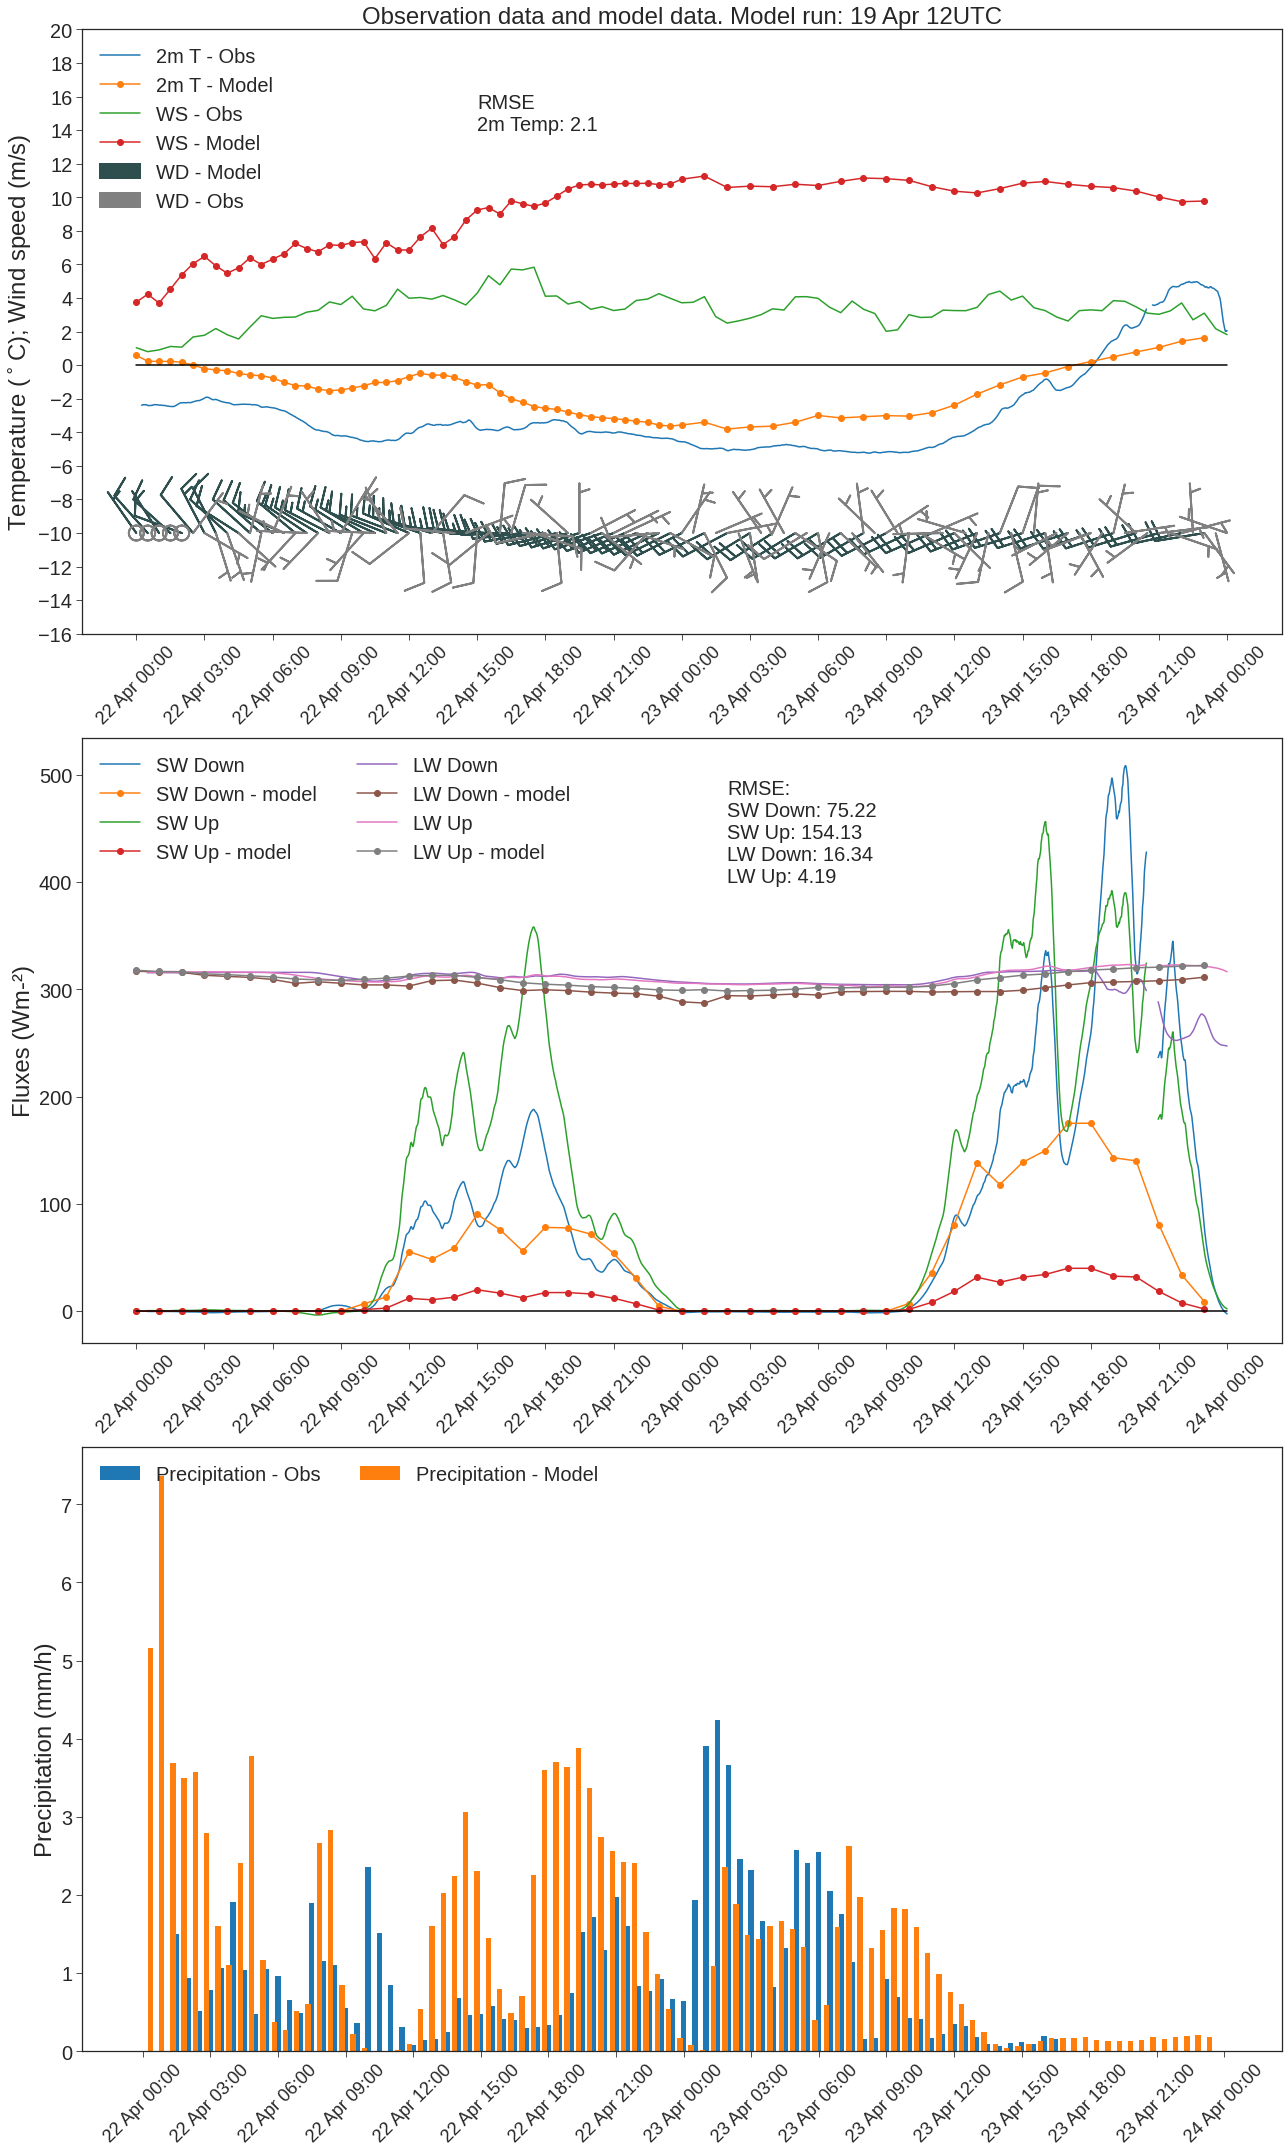

In [175]:
# Plotting

f, axs = plt.subplots(3, 1, figsize=(18, 30))

xticks = df_met['Timestamp'][::180]
#xticklabels = [x.strftime('%d %b %H:%M') for x in result['Timestamp']]

y = 2021
m = 4
d = 22
hour = 0
ax1 = axs[0]
# Temperature
ax1.plot(df_met['Timestamp'], df_met['Air_Temp'].rolling(window=15).mean(), label="2m T - Obs")
ax1.plot(df_t2m['Timestamp'], df_t2m['TT'], marker='o', label="2m T - Model")

# Wind Bards
ax1.barbs(df_t2m['Timestamp'], np.zeros([len(df_t2m['Timestamp'])])-10, df_t2m['UU']*1.944, df_t2m['VV']*1.944, zorder=1, length=10, color='darkslategray', label='WD - Model', lw=2)
ax1.barbs(df_wind['Timestamp'], np.zeros([len(df_wind['Timestamp'])])-10, df_wind['UU']*1.944, df_wind['VV']*1.944, zorder=1, length=10, color='gray', label='WD - Obs', lw=2)

# Wind Speed
#ax1t = ax1.twinx()
ax1.plot(df_wind['Timestamp'], df_wind['WS'], label="WS - Obs")
ax1.plot(df_t2m['Timestamp'], np.sqrt(np.power(df_t2m['UU'],2)+np.power(df_t2m['VV'],2)), marker='o', label="WS - Model")

# Black line on 0
ax1.plot([df_met['Timestamp'].iloc[0],df_met['Timestamp'].iloc[-1]], [0,0], color='k')
# RMSE Text
ax1.text(df_t2m['Timestamp'].iloc[30], 14, f"RMSE\n2m Temp: {rmse_TT:.2}", fontsize=20)
ax1.legend(fontsize=20, loc="upper left")

date_form = mtd.DateFormatter("%d %b %H:%M")
ax1.xaxis.set_major_formatter(date_form)

ax1.set_xticks(xticks)
#ax1.set_xticklabels(xticklabels, fontsize=20, rotation=45)
ax1.tick_params(axis='y', labelsize=20)
ax1.tick_params(axis='x', labelsize=18, rotation=45)
ax1.set_yticks(np.arange(-16,21,2))
ax1.set_ylabel('Temperature ($^\circ$C); Wind speed (m/s)', fontsize=24)

ax2 = axs[1]
# df.rolling(window=5).mean()
# Switched SW OUT and IN because the values were weird
ax2.plot(df_met['Timestamp'], df_met['SW_Downwelling'].rolling(window=30).mean(), label='SW Down')
#ax2.plot(df_flux['Timestamp'], df_flux['SW_IN'], label='SW Down')
ax2.plot(df_m_flux['Timestamp'], df_m_flux['FB'], marker='o', label='SW Down - model')
ax2.plot(df_met['Timestamp'], df_met['SW_Upwelling'].rolling(window=30).mean(), label='SW Up')
#ax2.plot(df_flux['Timestamp'], df_flux['SW_OUT'], label='SW Up')
ax2.plot(df_m_flux['Timestamp'], df_m_flux['SW_up'], marker='o', label='SW Up - model')
ax2.plot(df_met['Timestamp'], df_met['LW_Downwelling'].rolling(window=30).mean(), label='LW Down')
#ax2.plot(df_flux['Timestamp'], df_flux['LW_IN'], label='LW Down')
ax2.plot(df_m_flux['Timestamp'], df_m_flux['FI'], marker='o', label='LW Down - model')
ax2.plot(df_met['Timestamp'], df_met['LW_Upwelling'].rolling(window=30).mean(), label='LW Up')
#ax2.plot(df_flux['Timestamp'], df_flux['LW_OUT'], label='LW Up')
ax2.plot(df_m_flux['Timestamp'], df_m_flux['LW_up'], marker='o', label='LW Up - model')
#ax2.plot(df_met['Timestamp'], df_met['SW_Downwelling'] - df_met['SW_Upwelling'] + df_met['LW_Downwelling'] - df_met['LW_Upwelling'])
ax2.plot([df_met['Timestamp'].iloc[0],df_met['Timestamp'].iloc[-1]], [0,0], color='k')

# RMSE Text
# For 0 and 12
ax2.text(df_t2m['Timestamp'].iloc[50], 400, f"RMSE:\nSW Down: {rmse_SWIN:3.2f}\nSW Up: {rmse_SWOUT:3.2f}\nLW Down: {rmse_LWIN:3.2f}\nLW Up: {rmse_LWOUT:3.2f}", fontsize=20)
# For 6 and 18
#ax2.text(df_t2m['Timestamp'].iloc[0], 700, f"RMSE:\nSW Down: {rmse_SWIN:3.2f}\nSW Up: {rmse_SWOUT:3.2f}\nLW Down: {rmse_LWIN:3.2f}\nLW Up: {rmse_LWOUT:3.2f}", fontsize=20)

ax2.legend(loc="upper left", ncol = 2, fontsize=20)
#bbox_to_anchor =(0.15, 0.5)
ax2.xaxis.set_major_formatter(date_form)

ax2.set_xticks(xticks)
#ax1.set_xticklabels(xticklabels, fontsize=20, rotation=45)
ax2.tick_params(axis='y', labelsize=20)
ax2.tick_params(axis='x', labelsize=18, rotation=45)
ax2.set_ylabel('Fluxes (Wm-²)', fontsize=24)

ax3 = axs[2]

#xpr = np.arange(0,len(aux_pr))
ax3.bar(aux_temp, aux_pr, width=0.01, label='Precipitation - Obs')
ax3.bar(ind.values, pr_model, width=0.01, label='Precipitation - Model')

ax3.legend(loc="upper left", ncol = 2, fontsize=20)
#bbox_to_anchor =(0.15, 0.5)
ax3.xaxis.set_major_formatter(date_form)

ax3.set_xticks(xticks)
#ax1.set_xticklabels(xticklabels, fontsize=20, rotation=45)
ax3.tick_params(axis='y', labelsize=20)
ax3.tick_params(axis='x', labelsize=18, rotation=45)
ax3.set_ylabel('Precipitation (mm/h)', fontsize=24)

ax1.set_title("Observation data and model data. Model run: 19 Apr 12UTC", fontsize=24)
#plt.show()
plt.tight_layout()
plt.savefig(f'model_and_obs_{m}_{d}_{hour}UTC.png')

In [44]:
df_flux2 = df_flux.copy()
df_flux2['SW_IN'] = df_flux2['SW_IN'].astype(float)
df_flux2['SW_OUT'] = df_flux2['SW_OUT'].astype(float)
df_flux2['LW_IN'] = df_flux2['LW_IN'].astype(float)
df_flux2['LW_OUT'] = df_flux2['LW_OUT'].astype(float)

In [173]:
for a, b, c, d in zip(aux_temp, ind.values, aux_pr, pr_model):
    print(a,b, c, d)

2021-04-22 00:00:00 2021-04-21T23:50:00.000000000 nan 0
2021-04-22 00:30:00 2021-04-22T00:20:00.000000000 nan 5.1554173696786165
2021-04-22 01:00:00 2021-04-22T00:50:00.000000000 nan 7.366985036060214
2021-04-22 01:30:00 2021-04-22T01:20:00.000000000 1.4948333333333332 3.6835212260484695
2021-04-22 02:00:00 2021-04-22T01:50:00.000000000 0.9316666666666666 3.496262803673744
2021-04-22 02:30:00 2021-04-22T02:20:00.000000000 0.5185333333333333 3.580205887556076
2021-04-22 03:00:00 2021-04-22T02:50:00.000000000 0.7858999999999999 2.7900472283363342
2021-04-22 03:30:00 2021-04-22T03:20:00.000000000 1.0593 1.607012003660202
2021-04-22 04:00:00 2021-04-22T03:50:00.000000000 1.9163333333333337 1.1040005832910538
2021-04-22 04:30:00 2021-04-22T04:20:00.000000000 1.0389333333333335 2.409384772181511
2021-04-22 05:00:00 2021-04-22T04:50:00.000000000 0.4744333333333334 3.7740223109722137
2021-04-22 05:30:00 2021-04-22T05:20:00.000000000 1.0462333333333331 1.1631835252046585
2021-04-22 06:00:00 202

In [105]:
df_dis['Intensity of precipitation (mm/h)'].dropna()

30325    0.000
30326    1.579
30327    1.570
30328    1.826
30329    2.356
         ...  
33116    0.000
33117    0.000
33118    0.000
33119    0.000
33120    0.000
Name: Intensity of precipitation (mm/h), Length: 2796, dtype: float64

In [120]:
aux_temp = []
aux_pr = []
aux = []
for ts, pr in zip(df_dis['Timestamp'], df_dis['Intensity of precipitation (mm/h)']):
    #print(ts.minute)
    if not np.isnan(pr):
        aux.append(pr)
    if ts.minute == 30 or ts.minute == 0:        
        aux_temp.append(ts)
        aux_pr.append(np.mean(aux))
        aux = []

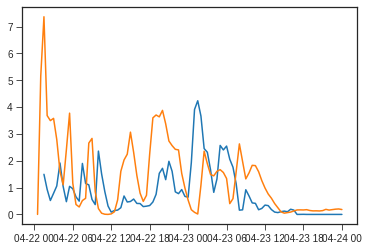

In [123]:
plt.plot(aux_temp, aux_pr)
plt.plot(aux_temp[1:], pr_model)

In [126]:
np.nansum(aux_pr),np.nansum(pr_model)

(78.94153333333333, 130.64814805984497)

In [114]:
df_model.RT*3600*1000

0     0.000000
1     3.419816
2     3.057718
3     1.716614
4     1.984835
        ...   
91    0.080466
92    0.107288
93    0.107288
94    0.120699
95    0.080466
Name: RT, Length: 96, dtype: float64

In [78]:
pr_model = df_model.PR[1:] - df_model.PR[:-1]

In [102]:
pr_model = []
aux = 0
for i, item in enumerate(df_model.PR):
    if i == 0:
        pr_model.append(0)
        continue    
    pr_model.append((item - aux)*3600)
    aux = item    

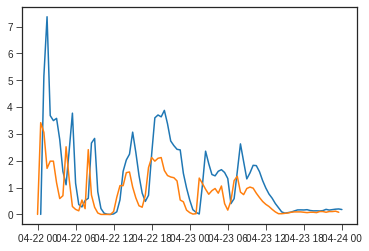

In [115]:
plt.plot(aux_temp[1:], pr_model)
plt.plot(df_model.Timestamp, df_model.RT*3600*1000)

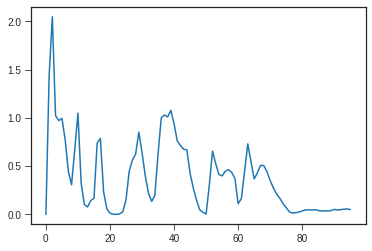

In [98]:
plt.plot(pr_model)